In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#!pip install progressbar
#import progressbar

import os

from surprise import Reader, Dataset
from surprise.model_selection import train_test_split, cross_validate

from sklearn.metrics.pairwise import linear_kernel

# L'etude de dataset

### Articles_metadata
* article_id : unique id for the article
* category_id : the category of the article, there is 461 category.
* created_at_ts : timestamp when the article as been created. You should remove the 3 last numbers. Oldest article : 2006/09/27 11:14:35. Newest : 2018/3/13 12:12:30.
* publisher_id : seems empty. only 0
* words_count : how many words in the article. From 0 to 6690. Distribution is available in few cells.

In [2]:
articles_metadata = pd.read_csv('../input/news-portal-user-interactions-by-globocom/articles_metadata.csv')  
articles_metadata

,article_id,category_id,created_at_ts,publisher_id,words_count
0,0,0,1513144419000,0,168
1,1,1,1405341936000,0,189
2,2,1,1408667706000,0,250
3,3,1,1408468313000,0,230
4,4,1,1407071171000,0,162
...,...,...,...,...,...
364042,364042,460,1434034118000,0,144
364043,364043,460,1434148472000,0,463
364044,364044,460,1457974279000,0,177
364045,364045,460,1515964737000,0,126


In [3]:
#articles_metadata.words_count.hist(bins=50, range=(0,400))
#plt.title('How many words per article');

### Clicks_hours meaning
* user_id : unique id for the user.
* session_id : unique id for an user's session. Can appear multiple times because multiple clicks per session.
* session_start : timestamp of the session. 
* session_size : how many clicks per session. From 2 to 24. 
* click_article_id : the article that has been cliked on.
* click_environment : ..... There is only three types, and the type 4 takes more than 90%. 
* click_deviceGroup : must be the kind of device : computer, smartphone or tablet ?
* click_os : the operation system of the device.
* click_country : which country the user come from.
* click_region : same but for region.
* click_referrer_type : good question.


In [4]:
clicks_hour_010 = pd.read_csv('../input/news-portal-user-interactions-by-globocom/clicks/clicks/clicks_hour_010.csv')  
clicks_hour_010

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,7982,1506861381208892,1506861381000,3,338351,1506862455855,4,3,2,1,13,2
1,7982,1506861381208892,1506861381000,3,136590,1506862497989,4,3,2,1,13,1
2,7982,1506861381208892,1506861381000,3,30970,1506862527989,4,3,2,1,13,1
3,7983,1506861383431893,1506861383000,2,207122,1506861420685,4,1,17,1,16,2
4,7983,1506861383431893,1506861383000,2,108854,1506861450685,4,1,17,1,16,2
...,...,...,...,...,...,...,...,...,...,...,...,...
5267,9924,1506864977266936,1506864977000,2,68866,1506865253842,4,1,17,1,13,2
5268,9925,1506864979264937,1506864979000,4,263430,1506865904525,4,1,17,1,14,1
5269,9925,1506864979264937,1506864979000,4,182485,1506866660845,4,1,17,1,14,1
5270,9925,1506864979264937,1506864979000,4,7759,1506867174052,4,1,17,1,14,7


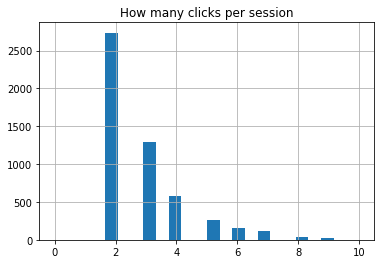

In [5]:
clicks_hour_010.session_size.hist(bins=24, range=(0,10))
plt.title('How many clicks per session');

In [6]:
clicks_hour_010.loc[clicks_hour_010.user_id == 0]

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type


In [7]:
clicks_hour_010.loc[clicks_hour_010.session_id == 1506864979264937]

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
5268,9925,1506864979264937,1506864979000,4,263430,1506865904525,4,1,17,1,14,1
5269,9925,1506864979264937,1506864979000,4,182485,1506866660845,4,1,17,1,14,1
5270,9925,1506864979264937,1506864979000,4,7759,1506867174052,4,1,17,1,14,7
5271,9925,1506864979264937,1506864979000,4,363018,1506867204052,4,1,17,1,14,7


# Methodes
to try 2 differents way to predict articles to the user.

* Baseline : Just like this video (https://www.youtube.com/watch?v=YMZmLx-AUvY), we are just going to recreate a matrix for the article and the user preferenced only based on previous clicks.
* Collaborative Filtering : We are going to use the surprise librairy. https://github.com/NicolasHug/Surprise


# Content-based : by category
## Traitement de données
Concate all clicks in one file

In [8]:
%%time

if not os.path.exists('clicks.csv'):
    clicks_path = []
    clicks_dir = "../input/news-portal-user-interactions-by-globocom/clicks/clicks"

    clicks_path = clicks_path + sorted(
            [
                os.path.join(clicks_dir, fname)
                for fname in os.listdir(clicks_dir)
                if fname.endswith(".csv")
            ]
        )
    print("Number of clicks csv:", len(clicks_path))

    _li = []

    for filename in clicks_path:
        df = pd.read_csv(filename, index_col=None, header=0)
        _li.append(df)

    clicks = pd.concat(_li, axis=0, ignore_index=True)
    clicks.to_csv('clicks.csv')
else:
    clicks= pd.read_csv('clicks.csv')
    
clicks

Number of clicks csv: 385
CPU times: user 28.1 s, sys: 2.54 s, total: 30.6 s
Wall time: 34.5 s


,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2
...,...,...,...,...,...,...,...,...,...,...,...,...
2988176,10051,1508211372158328,1508211372000,2,84911,1508211557302,4,3,2,1,25,1
2988177,322896,1508211376302329,1508211376000,2,30760,1508211672520,4,1,17,1,25,2
2988178,322896,1508211376302329,1508211376000,2,157507,1508211702520,4,1,17,1,25,2
2988179,123718,1508211379189330,1508211379000,2,234481,1508211513583,4,3,2,1,25,2


We need to group every article click per user.

In [9]:
df = clicks.groupby('user_id').agg(
    LIST_click_article_id = ('click_article_id', lambda x: list(x)),
)
df

,LIST_click_article_id
user_id,
0,"[157541, 68866, 96755, 313996, 160158, 233470,..."
1,"[235840, 96663, 59758, 160474, 285719, 156723,..."
2,"[119592, 30970, 30760, 209122]"
3,"[236065, 236294, 234686, 233769, 235665, 23513..."
4,"[48915, 44488, 195887, 195084, 63307, 336499, ..."
...,...
322892,"[42567, 39894]"
322893,"[50644, 36162]"
322894,"[36162, 168401]"


In [10]:
%%time
#Code need optimization

if not os.path.exists('../input/p9-data/df.csv'):
    #pbar = progressbar.ProgressBar(widgets=[progressbar.Percentage(), progressbar.Bar()], maxval=len(df)).start()
    
    df['categories'] = ''

    for index, row in df.iterrows():
       # pbar.update(index)
        _list_row = []
        for article in row.LIST_click_article_id:
            _list_row.append(articles_metadata[articles_metadata.article_id == article].category_id.values[0])
        df.loc[index]['categories']=_list_row
    df.to_csv('df.csv')
   # pbar.finish()
else:
    df= pd.read_csv('../input/p9-data/df.csv')

CPU times: user 716 ms, sys: 112 ms, total: 828 ms
Wall time: 1.43 s


In [11]:
df

,user_id,LIST_click_article_id,categories
0,0,"[157541, 68866, 96755, 313996, 160158, 233470,...","[281, 136, 209, 431, 281, 375, 186, 186]"
1,1,"[235840, 96663, 59758, 160474, 285719, 156723,...","[375, 209, 123, 281, 412, 281, 331, 412, 435, ..."
2,2,"[119592, 30970, 30760, 209122]","[247, 26, 26, 332]"
3,3,"[236065, 236294, 234686, 233769, 235665, 23513...","[375, 375, 375, 375, 375, 375, 281, 375, 375, ..."
4,4,"[48915, 44488, 195887, 195084, 63307, 336499, ...","[92, 81, 317, 317, 132, 437, 399]"
...,...,...,...
322892,322892,"[42567, 39894]","[67, 66]"
322893,322893,"[50644, 36162]","[99, 43]"
322894,322894,"[36162, 168401]","[43, 297]"
322895,322895,"[289197, 63746]","[418, 133]"


Now we have article_id and category_id that users clicked on.

## Calculate clicks per user
How many time an user clicked on a article from X category_id.

In [12]:
def inputUserRatings(userId):
    _matrix = pd.DataFrame(columns=['click'])
    _row = df.loc[userId]['categories']
    _row = _row.replace('[', '').replace(']', '').replace(',', '').split()
    
    for index, val in pd.Series(_row).value_counts().items():
        _matrix.loc[index] = int(val)
         
    _matrix['click_norm'] = _matrix.apply(lambda x : x / _matrix['click'].max())
    _matrix = _matrix.reset_index()
    _matrix = _matrix.rename(columns={"index": "category_id"})
    _matrix['category_id'] = _matrix['category_id'].astype(int)
    
    return _matrix

In [13]:
inputUserRatings(0)

,category_id,click,click_norm
0,281,2,1.0
1,186,2,1.0
2,136,1,0.5
3,209,1,0.5
4,431,1,0.5
5,375,1,0.5


## Recommend books from the 360 000 books available based on prefered category_id.

In [14]:
articles_matrix = articles_metadata.loc[:, ['article_id', 'category_id']]
display(articles_matrix.dtypes)

article_id     int64
category_id    int64
dtype: object

In [15]:
def recommend5(userId, articles_matrix):
    _input_user_ratings = inputUserRatings(userId)
    _articles_matrix = articles_matrix
    
    _weighed_articles_matrix = pd.DataFrame(columns=['article_id', 'category_id', 'weight'])
    _weighed_articles_matrix['article_id'] = _articles_matrix['article_id']
    _weighed_articles_matrix['category_id'] = _articles_matrix['category_id']
    #display(_weighed_articles_matrix.dtypes)

    _weighed_articles_matrix['weight'] = _weighed_articles_matrix['category_id'].apply(lambda x :
                                                                                        0                                                                                           
                                                                                       if(_input_user_ratings.loc[_input_user_ratings['category_id'] == x].empty == True)
                                                                                       else
                                                                                        _input_user_ratings.loc[_input_user_ratings['category_id'] == x].click_norm.values[0]
                                                                                      )

    
    return _weighed_articles_matrix[_weighed_articles_matrix.weight > 0].sort_values(by=['weight'], ascending=False)

In [16]:
%%time
res = recommend5(322892 , articles_matrix)
res

CPU times: user 2min 2s, sys: 4.7 s, total: 2min 7s
Wall time: 1min 59s


,article_id,category_id,weight
39159,39159,66,1.0
41807,41807,67,1.0
41719,41719,67,1.0
41720,41720,67,1.0
41721,41721,67,1.0
...,...,...,...
40447,40447,67,1.0
40448,40448,67,1.0
40449,40449,67,1.0
40450,40450,67,1.0


//lent algo%%time
res = recommend5(322892 , articles_matrix)
res

In [17]:
%%time
res1 = recommend5(3 , articles_matrix)
res1

CPU times: user 2min 18s, sys: 4.4 s, total: 2min 22s
Wall time: 2min 15s


,article_id,category_id,weight
231678,231678,375,1.000000
228804,228804,375,1.000000
228811,228811,375,1.000000
228810,228810,375,1.000000
228809,228809,375,1.000000
...,...,...,...
157711,157711,281,0.076923
157710,157710,281,0.076923
157709,157709,281,0.076923
157708,157708,281,0.076923


# Collaborative filtering
Let's try with using the surprise librairy.
https://medium.com/hacktive-devs/recommender-system-made-easy-with-scikit-surprise-569cbb689824
## Prepare data

In [18]:
clicks.head()

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2


In [19]:
articles_metadata.head()

,article_id,category_id,created_at_ts,publisher_id,words_count
0,0,0,1513144419000,0,168
1,1,1,1405341936000,0,189
2,2,1,1408667706000,0,250
3,3,1,1408468313000,0,230
4,4,1,1407071171000,0,162


In [20]:
%%time
dataframe = clicks.merge(articles_metadata, left_on='click_article_id', right_on='article_id')

CPU times: user 3.05 s, sys: 688 ms, total: 3.74 s
Wall time: 3.74 s


In [21]:
dataframe = dataframe[['user_id', 'article_id', 'category_id']]
dataframe

,user_id,article_id,category_id
0,0,157541,281
1,20,157541,281
2,44,157541,281
3,45,157541,281
4,76,157541,281
...,...,...,...
2988176,195186,2221,1
2988177,75658,271117,399
2988178,217129,20204,9
2988179,217129,70196,136


In [22]:
%%time
temp = dataframe.groupby(['user_id', 'category_id']).size()
user_rating_matrix = temp.to_frame()
user_rating_matrix = user_rating_matrix.reset_index()
user_rating_matrix.rename(columns = {0:'rate'}, inplace = True)

CPU times: user 2.64 s, sys: 75.4 ms, total: 2.72 s
Wall time: 2.72 s


In [23]:
user_rating_matrix

,user_id,category_id,rate
0,0,136,1
1,0,186,2
2,0,209,1
3,0,281,2
4,0,375,1
...,...,...,...
1882297,322894,297,1
1882298,322895,133,1
1882299,322895,418,1
1882300,322896,26,1


 here it's a dataframe with every user.

In [24]:
reader = Reader(rating_scale=(1,10))
_x = user_rating_matrix.loc[user_rating_matrix.rate > 1]
data = Dataset.load_from_df(_x[['user_id', 'category_id', 'rate']], reader)

print('We have selects', len(_x), 'interactions.')

We have selects 503616 interactions.


## Regarder pour plus tard : surprise librairy

In [25]:
%%time
trainset, testset = train_test_split(data, test_size=0.25)
print('Test set lenght :', len(testset))
print('Train set lenght :', len(_x) - len(testset))

Test set lenght : 125904
Train set lenght : 377712
CPU times: user 1.43 s, sys: 50.4 ms, total: 1.48 s
Wall time: 1.48 s


In [26]:
%%time
from surprise import SVD, accuracy
algo = SVD()
algo.fit(trainset)

CPU times: user 42.6 s, sys: 18.7 ms, total: 42.7 s
Wall time: 42.7 s


In [27]:
%%time
predictions = algo.test(testset)
print('Number of predictions in Test set :', len(predictions))

Number of predictions in Test set : 125904
CPU times: user 1.33 s, sys: 0 ns, total: 1.33 s
Wall time: 1.33 s


In [28]:
%%time
accuracy.rmse(predictions)

RMSE: 7.4246
CPU times: user 91.1 ms, sys: 1.01 ms, total: 92.1 ms
Wall time: 91.8 ms


7.4245966237891245

In [29]:
from collections import defaultdict


def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n